In [41]:
import sys
sys.path.insert(1, '../datasets/')
from fasion_mnist import Dataset, DataLoader
from fasion_mnist import image_size, channels, batch_size

image_size = 28
channels = 1
batch_size = 128
dataset = Dataset()
dataloader = DataLoader()

In [2]:
import torch
from torch.optim import Adam
from models import Unet

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [3]:
from pathlib import Path
results_folder = Path("../results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [4]:
from torchvision.utils import save_image
from forward import timesteps
from samplers import sample
from losses import p_losses
from utils import num_to_groups


epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Loss: 0.4971710443496704
Loss: 0.1450914591550827
Loss: 0.08990737050771713
Loss: 0.07842179387807846
Loss: 0.05857508257031441
Loss: 0.05852915346622467
Loss: 0.06540702283382416
Loss: 0.0616956390440464
Loss: 0.060013435781002045
Loss: 0.0571100153028965
Loss: 0.05389130860567093
Loss: 0.05228929966688156
Loss: 0.05384139344096184
Loss: 0.055216409265995026
Loss: 0.043042201548814774
Loss: 0.05090297758579254
Loss: 0.039567552506923676
Loss: 0.0457720048725605
Loss: 0.0458931140601635
Loss: 0.04669671133160591
Loss: 0.04843626543879509
Loss: 0.042360782623291016
Loss: 0.04743233323097229
Loss: 0.04013746976852417
Loss: 0.04985016956925392


In [42]:
from samplers import sample
%matplotlib inline
import matplotlib.pyplot as plt
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)
print(f'shape of samples: {samples[-1].shape}')


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

shape of samples: (64, 1, 28, 28)


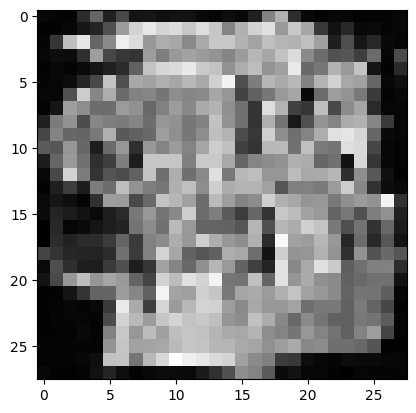

In [43]:

from random import randrange
random_index = randrange(0, 64)
# assert(samples[-1][random_index].shape == channels, image_size, image_size)
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

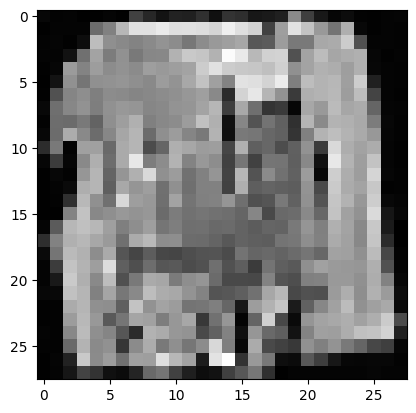

In [44]:
import matplotlib.animation as animation
%matplotlib inline
import matplotlib.pyplot as plt

random_index = randrange(0, 64)

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
# print(animate)
animate.save('diffusion.gif')
plt.show()